In [175]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import math

## Load Data

In [176]:
from pathlib import Path

data_dirs = [Path("./"), Path("../")]

tf = transforms.Compose([
    # 0.1307 is the mean of the MNIST dataset, 0.3081 is the standard deviation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), 
])

for data_dir in data_dirs:
    if (data_dir / "MNIST").exists():
        train_data = datasets.MNIST(data_dir, train=True, transform=tf)
        test_data = datasets.MNIST(data_dir, train=False, transform=tf)
        break
else:
    train_data = datasets.MNIST("./", train=True, download=True, transform=tf)
    test_data = datasets.MNIST("./", train=False, download=True, transform=tf)
    

g = torch.Generator().manual_seed(42)

train_data, val_data = random_split(train_data, [50000, 10000], generator=g)

## Model

### Patch


In [337]:
def patch(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    divide image into non-overlapping patches
    (B, C, H, W) -> (B, N, P*P*C) where N = (H/P)*(W/P)
    note: H and W must be divisible by P
    """
    if x.size(2) % patch_size != 0 or x.size(3) % patch_size != 0:
        raise ValueError("Height and Width must be divisible by patch_size")
    x = x.unfold(2,patch_size,patch_size).unfold(3,patch_size,patch_size)
    x = x.reshape(x.size(0), -1, patch_size * patch_size)
    return x

torch.Size([1, 1, 28, 28])
torch.Size([1, 49, 16])


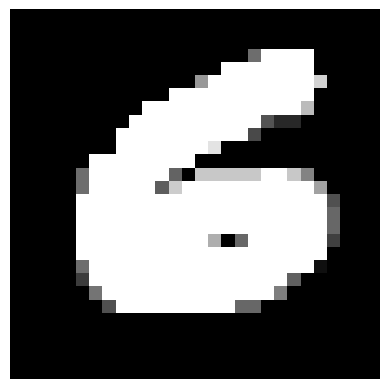

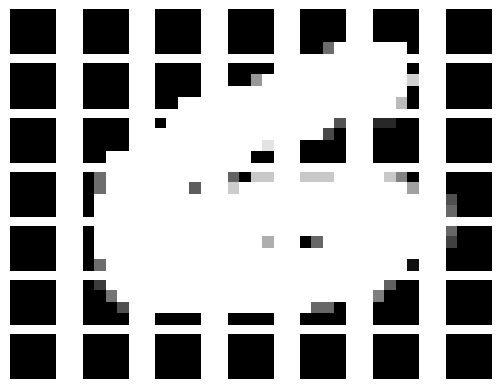

In [338]:
p = 4
inp  = train_data[0][0].unsqueeze(0)
print(inp.shape)
out = patch(inp, p)
print(out.shape)

plt.imshow(inp.squeeze(0,1), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

fig = plt.figure()
for i in range(out.size(1)):
    fig.add_subplot(inp.size(2)// p,inp.size(2)//p,i+1)
    plt.imshow(out.squeeze(0)[i].reshape(p, p) , cmap='gray', vmin=0, vmax=1)
    plt.axis('off')


### Tokenization

In [419]:
class Tokenization(nn.Module):
    def __init__(self, patch_dim, emb_dim):
        """
        Tokenization and add CLS token
        (B, N, P*P*C) -> (B, N+1, d)
        p_size = P*P*C
        """
        super().__init__()
        self.projection = nn.Linear(patch_dim, emb_dim)
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, 1, emb_dim))

    def forward(self, x:torch.Tensor):
        x = self.projection(x).squeeze(-2) # (B, N, 1, d) -> (B, N, d)
        cls_token = self.cls_token.expand(x.size(0), -1, -1) # (B, 1, d)
        pos_emb = self.pos_emb.expand(x.size(0), x.size(1) + 1, -1)
        return torch.cat((cls_token, x), dim = 1) + pos_emb

### Attention

In [420]:
class SelfAttention(nn.Module):
    """
    (B, N+1, d) -> (B, N+1, d_v)
    d_q = d_k = d_v = d here
    note: d_q must equal to d_k in self-attention
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.Q = nn.Linear(emb_dim, emb_dim)
        self.K = nn.Linear(emb_dim, emb_dim)
        self.V = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, x:torch.Tensor):
        R = self.Q(x) @ self.K(x).transpose(-1, -2)
        # (B, N+1, d) @ (B, d, N+1) -> (... N+1, N+1)
        #      Q             K               Q    K
        SA = (
            F.softmax(R / math.sqrt(self.emb_dim), -1) # soft max on K
            @ self.V(x))
        return SA

### Transformer

In [421]:
class Transformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.attention = SelfAttention(emb_dim)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*2),
            nn.GELU(),
            nn.Linear(emb_dim*2, emb_dim),
        )
    
    def forward(self, x):
        x = x + self.attention(self.norm1(x)) # residual connect
        return x + self.mlp(self.norm2(x))

In [422]:
# ref: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html#using-nn-sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [423]:
class ViT(nn.Module):
    def __init__(self, patch_size, d_model):
        super().__init__()
        self.model = nn.Sequential(
            Lambda(lambda x: patch(x, patch_size)),
            Tokenization(patch_size**2, d_model), # C == 1 in MNIST
            Transformer(d_model),
            Transformer(d_model),
            Transformer(d_model),
            # Head
            Lambda(lambda x: x[:,0,:]),
            nn.Linear(d_model, 10)
        )
        
    def forward(self, x):
        return self.model.forward(x)

## Train

In [426]:
import numpy as np
import math
from torch import Tensor

loss_func = F.cross_entropy

def accuracy(input:Tensor, target:Tensor):
    preds = torch.argmax(input, dim=1)
    return (preds == target).float().mean()

In [427]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model.forward(x_batch)
            total_acc += accuracy(preds, y_batch)
            total_loss += loss_func(preds, y_batch)
    return total_loss / len(loader), total_acc / len(loader)

def fit(model, optimizer, train_loader, val_loader, epochs, device):
    model.to(device)
    for epoch in range(epochs):
        loss_t = 0
        acc_t = 0
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model.forward(x_batch)
            loss = loss_func(preds, y_batch)
            loss_t += loss
            acc_t += accuracy(preds, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        print(f"epoch {epoch+1} loss (train): {loss_t / len(train_loader):.4f}, accuracy (train): {acc_t / len(train_loader):.4f}", end=" ")
        loss, acc = evaluate(model, val_loader, device)
        print(f"loss: {loss:.4f}, accuracy: {acc:.4f}")


In [ ]:
model = ViT(
    patch_size = 2,
    d_model = 128
)

print(next(model.named_modules())[1])
print(f"Params: {sum(p.numel() for p in model.parameters())}")

In [ ]:
bs = 128

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs*2, shuffle=True)

inp  = next(iter(train_loader))[0]
print(inp.shape)
out = model(inp)
print(out.shape)


In [ ]:
lr = 0.03
epochs = 10

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.0)

fit(model, optimizer, train_loader, val_loader, epochs, 'mps')

Save & Test